#CNN tutorial https://cambridgespark.com/content/tutorials/convolutional-neural-networks-with-keras/index.html

#https://github.com/cttsai1985/Kaggle-Statoil-Iceberg-Classifier-ConvNets/blob/master/scripts/cnn_predict.py
#https://www.learnopencv.com/image-classification-using-feedforward-neural-network-in-keras/

#radar stuff http://www.gfoi.org/wp-content/uploads/2016/10/PALSAR-Interpretation-Guide-v1.1.pdf

#image manipulation https://www.kaggle.com/muonneutrino/exploration-transforming-images-in-python
#iceberg challenge example https://www.kaggle.com/fvzaur/iceberg-ship-classification-with-cnn-on-keras

#about imagedatagenerator https://www.kaggle.com/hexietufts/easy-to-use-keras-imagedatagenerator

System Requirements
Processor: AMG Phenom(tm) II X6 1055T Processor 2.81 GHz 6-Core
Installed memory (RAM): 16.0GB
System type: 64-bit Operating System, x64 based processor
GPU: NVIDIA GeForce GTX 1050 Ti
Operating System: Windows 10 Pro

In [1]:
from keras import backend as K
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.utils import np_utils
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
#load training data
train = json.load(open('train.json'))

In [3]:
#load test data
test = json.load(open('test.json'))

# Pre-Processs

Here we start building the input layer

In [4]:
def normalize(X1):
    '''normalizes to 0 to 1 scale'''
    norm = ((X1-X1.min())/(X1.max()-X1.min()))
    return norm

def preprocess(data):
    '''
    preprocesses the data and returns two list of processed data, 
    one normalized on 0 to 1 scale, dual channel picture, 75x75x2
    one normalized to power ratio, and combined, single channel picture, 75x75x1
    '''
    #make empty list for dataset normalized from 0 to 1
    X_data_scale = list()

    #make empty list for dataset normalized by power ratio
    X_data_power = list()

    #itterate over each element of the data
    for i in range(len(data)):
        #get elements of entry
        id = (data[i]['id'])
        B1 = np.reshape(data[i]['band_1'], (75,75))
        B2 = np.reshape(data[i]['band_2'], (75,75))
        
        #normalize to 0 to 1 range
        B1_norm = normalize(B1)
        B2_norm = normalize(B2)
        norm_merge = np.dstack((B1_norm,B2_norm))
        
        #transform to power
        B1_power = np.power(10, np.divide(B1, 20))
        B2_power = np.power(10, np.divide(B2, 20))
        power_merge = normalize(np.multiply(10,np.log10(np.add(np.power(10,np.divide(B1_power,10)),np.power(10,np.divide(B2_power,10))))))

        #df.append({'id':id, 'image':norm_merge})
        #dp.append({'id':id, 'image':power_merge})
        X_data_scale.append(norm_merge)
        X_data_power.append(power_merge)
        
    return np.array(X_data_scale), np.array(X_data_power)

def get_classification(data):
    '''retrieves classification for each image in testing dataset'''
    y_data = list()
    for i in range(len(data)):
        #id = (data[i]['id'])
        classification = (data[i]['is_iceberg'])
        #target.append({'id':id, 'is_iceberg':classification})
        y_data.append([classification])
    return(np.array(y_data))

def get_id(data):
    '''retrieves classification for each image in testing dataset'''
    id = list()
    for i in range(len(data)):
        sample = (data[i]['id'])
        id.append([sample])
    return(np.array(id))

def get_angle(data):
    '''retrieves classification for each image in testing dataset'''
    angle = list()
    for i in range(len(data)):
        sample = (data[i]['inc_angle'])
        angle.append(sample)
    return(angle)

In [5]:
#preprocess training dataset
X_train_scale, X_train_power = preprocess(train)
y_train = get_classification(train)
train_id = get_id(train)

In [6]:
#preprocess testing dataset
X_test_scale, X_test_power = preprocess(test)
test_id = get_id(test)

# Visualize sample plot img

Plot img normalized from 0 to 1

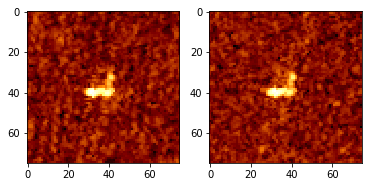

In [7]:
fig = plt.figure()
plt.subplot(121)
B1_norm = normalize(np.reshape(train[1]['band_1'], (75,75)))
plt.imshow(B1_norm, cmap='afmhot')
plt.subplot(122)
B2_norm = normalize(np.reshape(train[1]['band_2'], (75,75)))
plt.imshow(B2_norm, cmap='afmhot')
plt.show()

plot img transform to power ratio

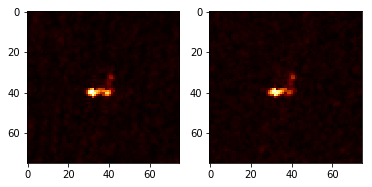

In [8]:
fig = plt.figure()
plt.subplot(121)
B1_power = np.power(10, np.divide(np.reshape(train[1]['band_1'], (75,75)), 20))
plt.imshow(B1_power, cmap='afmhot')
plt.subplot(122)
B2_power = np.power(10, np.divide(np.reshape(train[1]['band_2'], (75,75)), 20))
plt.imshow(B2_power, cmap='afmhot')
plt.show()

Merge normalized 0 to 1 scale plots

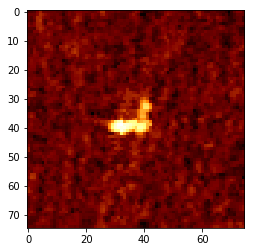

In [9]:
dd=(np.multiply(10,np.log10(np.add(np.power(10,np.divide(B1_norm,10)),np.power(10,np.divide(B2_norm,10))))))
plt.imshow(dd, cmap='afmhot')

Merge power ratio plots

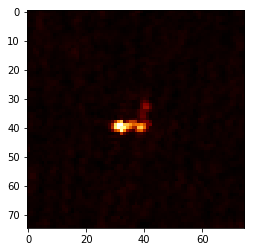

In [10]:
dm=(np.multiply(10,np.log10(np.add(np.power(10,np.divide(B1_power,10)),np.power(10,np.divide(B2_power,10))))))
plt.imshow(dm, cmap='afmhot')

We can see from the figures above, my transforming to power ratios, we remove alot of the background noise without reducing much of the target object's intensity.  I should consider keeping merged normalized scaled dataset and also 2 channel power ratio dataset to test.

#median filter probably wont use
#https://dsp.stackexchange.com/questions/24585/noise-remains-after-applying-median-filter

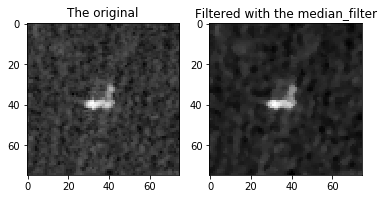

In [11]:
from scipy.ndimage.filters import median_filter
from matplotlib.pylab import imread, imshow, subplot, title, show, get_cmap

img = dd
new = median_filter(img, 3)

subplot(121); imshow(img, cmap=get_cmap('gray'));
title('The original')
subplot(122); imshow(new, cmap=get_cmap('gray'));
title('Filtered with the median_filter')

show()

# Add Augmented Data

Rotate 90, 180, 270, mirror lf, mirror ud

Keras ImageDataGenerator or np.rot90/np.flip

# Split training & testing data

In [12]:
#split training & testing set
from sklearn.model_selection import train_test_split
X_train_d_scale, X_test_d_scale, y_train_d_scale, y_test_d_scale = train_test_split(X_train_scale, y_train, test_size=0.2, random_state=0)

# Model Building

Define hyperparameters to be used for CNN

In [13]:
#hyperparameters
batch_size = 32 #number of training examples to consider at once
num_epochs = 200 #itterate n times over training set
kernel_size = 3 #3x3 kernal
pool_size = 2 #2x2 pooling
conv_depth_1 = 32 # first layer 32 kernals
conv_depth_2 = 64 # second layer 64 kernals
drop_prob_1 = 0.2 # probability of dropout after pooling
drop_prob_2 = 0.65 # probability of dropout in fully-connected layer
hidden_size = 512 #number of neurons in fully-connected layer

scaled dataset parameters

In [14]:
num_train, height, width, depth = X_train_scale.shape  #1604 training samples
num_test = X_test_scale.shape[0] #8424 testing samples
num_classes = np.unique(y_train).shape[0] #number of unique classes (iceberg: yes(1), no(0))

In [15]:
#one hot encoding labels
Y_train = np_utils.to_categorical(y_train_d_scale, num_classes)
Y_test = np_utils.to_categorical(y_test_d_scale, num_classes)

### Train model

In [16]:
inp = Input(shape=(height, width, depth)) 

# Conv [32] -> Conv [32] -> Pool (with dropout on the pooling layer)
conv_1 = Convolution2D(conv_depth_1, (kernel_size, kernel_size), padding='same', activation='relu')(inp)
conv_2 = Convolution2D(conv_depth_1, (kernel_size, kernel_size), padding='same', activation='relu')(conv_1)
pool_1 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_2)
drop_1 = Dropout(drop_prob_1)(pool_1)
# Conv [64] -> Conv [64] -> Pool (with dropout on the pooling layer)
conv_3 = Convolution2D(conv_depth_2, (kernel_size, kernel_size), padding='same', activation='relu')(drop_1)
conv_4 = Convolution2D(conv_depth_2, (kernel_size, kernel_size), padding='same', activation='relu')(conv_3)
pool_2 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_4)
drop_2 = Dropout(drop_prob_1)(pool_2)
# Now flatten to 1D, apply FC -> ReLU (with dropout) -> softmax
flat = Flatten()(drop_2)
hidden = Dense(hidden_size, activation='relu')(flat)
drop_3 = Dropout(drop_prob_2)(hidden)
out = Dense(num_classes, activation='softmax')(drop_3)

model = Model(inputs=inp, outputs=out) # To define a model, just specify its input and output layers

model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy

history = model.fit(X_train_d_scale, Y_train,                # Train the model using the training set...
          batch_size=batch_size, epochs=num_epochs,
          verbose=1, validation_split=0.1) # ...holding out 10% of the data for validation
model.evaluate(X_test_d_scale, Y_test, verbose=1)  # Evaluate the trained model on the test set!

Train on 1154 samples, validate on 129 samples
Epoch 1/200
1154/1154 [==============================] - 6s 5ms/step - loss: 0.7394 - acc: 0.5165 - val_loss: 0.6961 - val_acc: 0.4419
Epoch 2/200
1154/1154 [==============================] - 3s 2ms/step - loss: 0.6826 - acc: 0.5676 - val_loss: 0.7095 - val_acc: 0.4806
Epoch 3/200
1154/1154 [==============================] - 3s 2ms/step - loss: 0.6555 - acc: 0.5832 - val_loss: 0.6831 - val_acc: 0.6124
Epoch 4/200
1154/1154 [==============================] - 3s 2ms/step - loss: 0.6781 - acc: 0.5945 - val_loss: 0.6360 - val_acc: 0.6434
Epoch 5/200
1154/1154 [==============================] - 3s 2ms/step - loss: 0.6465 - acc: 0.6205 - val_loss: 0.6301 - val_acc: 0.6124
Epoch 6/200
1154/1154 [==============================] - 3s 2ms/step - loss: 0.6009 - acc: 0.6655 - val_loss: 0.6342 - val_acc: 0.6512
Epoch 7/200
1154/1154 [==============================] - 3s 2ms/step - loss: 0.6282 - acc: 0.6205 - val_loss: 0.5544 - val_acc: 0.6744
Epoch 8/

Epoch 61/200
1154/1154 [==============================] - 3s 2ms/step - loss: 0.0157 - acc: 0.9957 - val_loss: 0.5379 - val_acc: 0.8682
Epoch 62/200
1154/1154 [==============================] - 3s 2ms/step - loss: 0.0269 - acc: 0.9922 - val_loss: 0.6150 - val_acc: 0.8450
Epoch 63/200
1154/1154 [==============================] - 3s 2ms/step - loss: 0.0172 - acc: 0.9939 - val_loss: 0.5273 - val_acc: 0.8605
Epoch 64/200
1154/1154 [==============================] - 3s 2ms/step - loss: 0.0230 - acc: 0.9922 - val_loss: 0.8927 - val_acc: 0.8217
Epoch 65/200
1154/1154 [==============================] - 3s 2ms/step - loss: 0.0693 - acc: 0.9723 - val_loss: 0.5324 - val_acc: 0.8450
Epoch 66/200
1154/1154 [==============================] - 3s 2ms/step - loss: 0.0316 - acc: 0.9913 - val_loss: 0.4553 - val_acc: 0.8527
Epoch 67/200
1154/1154 [==============================] - 3s 2ms/step - loss: 0.0161 - acc: 0.9965 - val_loss: 0.5119 - val_acc: 0.8450
Epoch 68/200
1154/1154 [========================

1154/1154 [==============================] - 3s 2ms/step - loss: 0.0066 - acc: 0.9983 - val_loss: 0.7123 - val_acc: 0.8450
Epoch 122/200
1154/1154 [==============================] - 3s 2ms/step - loss: 0.0064 - acc: 0.9983 - val_loss: 0.7453 - val_acc: 0.8372
Epoch 123/200
1154/1154 [==============================] - 3s 2ms/step - loss: 0.0049 - acc: 0.9983 - val_loss: 0.6484 - val_acc: 0.8527
Epoch 124/200
1154/1154 [==============================] - 3s 2ms/step - loss: 0.0052 - acc: 0.9983 - val_loss: 0.7399 - val_acc: 0.8140
Epoch 125/200
1154/1154 [==============================] - 3s 2ms/step - loss: 0.0098 - acc: 0.9974 - val_loss: 0.7516 - val_acc: 0.8605
Epoch 126/200
1154/1154 [==============================] - 3s 2ms/step - loss: 0.0077 - acc: 0.9991 - val_loss: 0.8072 - val_acc: 0.8450
Epoch 127/200
1154/1154 [==============================] - 3s 2ms/step - loss: 0.0084 - acc: 0.9974 - val_loss: 0.6847 - val_acc: 0.8217
Epoch 128/200
1154/1154 [==============================

Epoch 181/200
1154/1154 [==============================] - 3s 2ms/step - loss: 0.0040 - acc: 0.9991 - val_loss: 0.8892 - val_acc: 0.7984
Epoch 182/200
1154/1154 [==============================] - 3s 2ms/step - loss: 0.0031 - acc: 0.9983 - val_loss: 0.7894 - val_acc: 0.8140
Epoch 183/200
1154/1154 [==============================] - 3s 2ms/step - loss: 0.0053 - acc: 0.9983 - val_loss: 1.0211 - val_acc: 0.8140
Epoch 184/200
1154/1154 [==============================] - 3s 2ms/step - loss: 0.0108 - acc: 0.9948 - val_loss: 0.8633 - val_acc: 0.8295
Epoch 185/200
1154/1154 [==============================] - 3s 2ms/step - loss: 0.0055 - acc: 0.9991 - val_loss: 0.6848 - val_acc: 0.8450
Epoch 186/200
1154/1154 [==============================] - 3s 2ms/step - loss: 0.0134 - acc: 0.9957 - val_loss: 0.4637 - val_acc: 0.8605
Epoch 187/200
1154/1154 [==============================] - 3s 2ms/step - loss: 0.0104 - acc: 0.9983 - val_loss: 0.7836 - val_acc: 0.8527
Epoch 188/200
1154/1154 [================

[1.0268622640073533, 0.8099688473520249]

### Predict using model

In [17]:
dd=model.predict(X_test_scale,batch_size=batch_size,verbose=1)

8424/8424 [==============================] - 5s 630us/step


### Output results

In [18]:
results = pd.DataFrame()

for i in range(len(test_id)):
    results = results.append({'id': test_id[i][0], 'is_iceberg' :dd[i][1]}, ignore_index=True)

results.to_csv("results.csv",index=False)

### Plot history of accuracy and loss

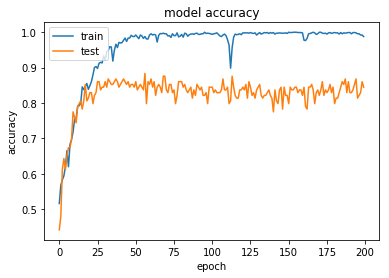

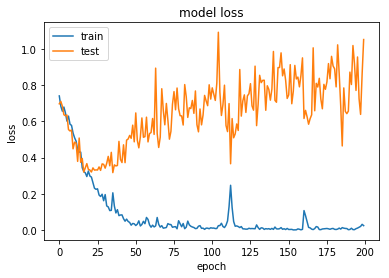

In [19]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Plot model

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 75, 2)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        608       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 64)        36928     
__________